In [1]:
import numpy as np
# np.seterr(all='raise')
np.seterr(under='ignore', invalid='raise', divide='raise', over='raise')
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kv  # K_v BESSEL FUNCTIONS
from scipy.special import zeta, polygamma, factorial
import matplotlib as mpl
from mpmath import zeta
from itertools import cycle
from functions import m_sv_interp, gstar_interp
from scipy.special import kve

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})


In [2]:
Mpl = 1.2209e19
GSTAR = 90.0
GSTAR_S = 90.0

path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]
def gstar_interp(T):
    return np.interp(T, T_data, g_eff)

In [3]:
#####
# CONSTANTS
#######
# ----------------------------
# Constant values
# ----------------------------
GSTAR = 90.0
GSTAR_S = 90.0
ME = 0.000511e-3  # GeV
ALPHA_EM = 1.0/137.0
MPL   = 1.2209e19      # GeV
INCLUDE_HS_IN_H = True

# --- unit conversions: cm^3/s -> GeV^-2 ---
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3s_to_GeV2  = (cm_to_GeV_inv**3) / s_to_GeV_inv
Gev2_to_cm3s = 1.0 / cm3s_to_GeV2

In [8]:
#####
# Model parameters and functions
#######

# ----------------------------
# Functions for cross sections
# ----------------------------
def gD_of_alpha(alphaD):           # g_D from alpha_D
    return np.sqrt(4.0*np.pi*alphaD)

def sigma_xx_to_AA(alphaD, mchi, mA):
    gD = gD_of_alpha(alphaD)
    r = mA / mchi
    amplitude = 16*gD**4 * (1 - r**2)/(9 * (r**2 - 2)**2)
    phase_space = 9 * np.sqrt(1 - r**2) / (64* np.pi * mchi**2)
    return amplitude * phase_space

def sigmav_chichi_ee(epsilon, alphaD, mchi, mA):
    # source:1702.07716 (app)
    if mchi <= ME:
        return 0.0 # kinematically forbidden
    r   = mA / mchi
    e2  = 4.0*np.pi*ALPHA_EM
    gD  = gD_of_alpha(alphaD)
    pref = 4.0 * e2 * (epsilon**2) * (gD**2)
    num  = (2.0 + (ME**2)/(mchi**2))
    den  = (r**2 - 4.0)**2

    phase_space  = np.sqrt(1.0 - (ME**2)/(mchi**2)) / (8.0*np.pi*mchi**2)
    return pref * (num/den) * phase_space

def gammaA_ee(epsilon, mA):
    pref = epsilon**2 * ALPHA_EM / 3.0
    return pref * mA * (1 + 2*(ME**2)/(mA**2)) * np.sqrt(1 - 4*(ME**2)/(mA**2))

# ----------------------------
# ----------------------------
# Model parameters
# ----------------------------


In [ ]:
# ----------------------------
# Entropy functions
# ----------------------------
def gstar_SM(T, t_dep = False):
    if t_dep:
        gstar_s = gstar_interp(T)
    else:
        gstar_s = GSTAR_S
    return  gstar_s
    #return GSTAR

def gstars_SM(T, t_dep = False):
    return gstar_SM(T, t_dep)
    #return GSTAR_S


def dln_gstars_SM_dlnT(T, t_dep = False, delta=1e-6):
    """Numerical derivative of ln(g*_s) w.r.t. ln(T)."""
    if t_dep:
        gstar_plus = gstar_interp(T * (1.0 + delta))
        gstar_minus = gstar_interp(T * (1.0 - delta))
        return (np.log(gstar_plus) - np.log(gstar_minus)) / (2.0 * np.log(1.0 + delta))
    else:
        return 0


# ----------------------------
# Helper thermo stuff
# ----------------------------
def H_of_T(T, rho_h=0.0, t_dep = False):
    """Hubble from SM  + HS """
    ## typically by freezeout, all radiation energy has been deposited into non-rel species
    ## technically more correct to include
    rho_SM = (np.pi**2/30.0) * gstar_SM(T, t_dep) * T**4
    if INCLUDE_HS_IN_H:
        rho_tot = rho_SM + rho_h
    else:
        rho_tot = rho_SM
    return np.sqrt((8.0*np.pi/3.0) * rho_tot) / MPL

def s_SM(T, t_dep = False):
    """SM entropy density"""
    return (2.0*np.pi**2/45.0) * gstars_SM(T, t_dep) * T**3


def dx_dt(T, H, m, t_dep = False):
    """dx/dt for x = mchi / T."""
    x = m / T
    corr = 1.0 + (1.0/3.0) * dln_gstars_SM_dlnT(T, t_dep)
    return H * x / corr


def neq(m, g, T):
    """equilibrium number density at temperature T - Use bessels"""
    x = m / T
    return g * (m**2*T) / (2.0*np.pi**2) * kv(2, x)

LOG_TINY = -745.0      # ~ log(np.finfo(float).tiny)
VAL_FLOOR = 1e-100     # positive floor

def rho_i_exact(n_i, m_i, Th):
    # source: 2504.00077, eqn 2.15
    Th   = np.maximum(Th, VAL_FLOOR)        # avoid z = inf / division by zero
    z    = m_i / Th
    # Use scaled Kv: Kv(z) = e^{-z} kve(order, z);  ratio is stable as kve(1)/kve(2)
    k2   = kve(2, z)
    ratio = kve(1, z) / np.maximum(k2, VAL_FLOOR)
    return n_i * (m_i * ratio + 3.0 * Th)

def P_i_exact(n_i, Th):
    # source: 2504.00077, eqn 2.15
    # MB equation of state is ideal-gas exactly: P = n T
    return n_i * Th



def safe_exp(logx):
    """exp(logx) with an underflow clamp to 0 ."""
    return np.exp(np.maximum(logx, LOG_TINY))

def ln_neq(m, g, T):
    """
    ln n_eq = ln[g m^2 T /(2π^2)] + ln K2(m/T)
            = ln[g m^2 T /(2π^2)] + (-z + ln kve(2, z)),  z = m/T
    """
    z = m / T
    return (np.log(g) + 2*np.log(m) + np.log(T) - np.log(2*np.pi**2)
            - z + np.log(kve(2, z)))


def _R(z):
    #ratio of bessels K1(z)/K2(z)
    return kve(1, z) / kve(2, z)  # stable, exp factors cancel

def _dR_dz(z, rel_step=1e-6):
    #z = max(z, 1e-12)
    dz = np.maximum(rel_step * z, 1e-6)
    Rp = kve(1, z+dz)/kve(2, z+dz)
    Rm = kve(1, z-dz)/kve(2, z-dz)
    return (Rp - Rm) / (2.0*dz)

def dTh_dt_rel(nchi, nA, Th, mchi, mA, H, rhoh, Ph, Qh, dnchi_dt, dnA_dt):
    zc = mchi /np.maximum(Th, 1e-300)
    zA = mA   / np.maximum(Th, 1e-300)

    Rchi = _R(zc)
    RA = _R(zA)
    dRchi_dz = _dR_dz(zc)
    dRA_dz = _dR_dz(zA)

    # h_i
    h_chi = mchi * Rchi + 3.0 * Th
    h_A   = mA   * RA   + 3.0 * Th

    # C_h = sum n_i [ 3 - z_i^2 dR/dz ] HEAT CAPACITY at constant composition
    Ch = nchi * (3.0 - zc*zc * dRchi_dz) + nA * (3.0 - zA*zA * dRA_dz)
    Ch = max(Ch, 1e-300)

    numer = Qh - (h_chi * dnchi_dt + h_A * dnA_dt) - 3.0 * H * (rhoh + Ph)
    return numer / Ch


# ----------------------------
# Collision terms
# ----------------------------

# def collisions_old(params, nchi, gchi, nA, T, Th):
#     # equilibrium distributions:

#     gamma_Aee = params["gamma_Aee"]
#     sv_xxee = params["sv_xxee"]
#     sv_xxAA = params["sv_xxAA"]
#     mchi = params["mchi"]
#     mA = params["mA"]
#     gA = params["gA"]
#     gchi = params["gchi"]

#     nchi_eq_SM = neq(mchi, gchi, T)
#     nA_eq_SM = neq(mA,  gA, T)
#     nA_eq_Th  = neq(mA,  gA,  Th)
#     nchi_eq_Th = neq(mchi, gchi, Th)
#     zA = mA / Th
#     lorentz = kv(1, zA) / kv(2, zA)      # <m/E>_Th
#     # number collision terms:
#     C_chi = -0.5 * sv_xxee * (nchi**2 - nchi_eq_SM**2) \
#             - sv_xxAA * (nchi**2  - (nchi_eq_Th**2 / nA_eq_Th**2) * nA**2)

#     C_A  =  sv_xxAA * (nchi**2 - (nchi_eq_Th**2 / nA_eq_Th**2) * nA**2) \
#            - gamma_Aee * lorentz * (nA - nA_eq_SM)
#     Q_ann = - 0.5 * mchi * sv_xxee * (nchi**2 - nchi_eq_SM**2)

#     ## decay contribution to energy transfer - lorentz factors cancel
#     Q_dec = - mA * gamma_Aee * (nA - nA_eq_SM)  # use SM temp, final states are in eq with SM bath
#     Q_h =  Q_ann + Q_dec # energy transfer to HS
#     return C_chi, C_A, Q_h

def collisions(params, nchi, nA, T, Th):
    mchi = params["mchi"]; mA = params["mA"]
    gchi = params["gchi"]; gA = params["gA"]
    sv_xxee = params["sv_xxee"]; sv_xxAA = params["sv_xxAA"]
    gamma_Aee = params["gamma_Aee"]

    # log equilibrium densities (SM at T, HS at Th)
    ln_nchi_eq_SM = ln_neq(mchi, gchi, T)
    ln_nA_eq_SM   = ln_neq(mA,   gA,   T)
    ln_nchi_eq_Th = ln_neq(mchi, gchi, Th)
    ln_nA_eq_Th   = ln_neq(mA,   gA,   Th)

    # Detailed-balance factor: (nchi_eq_Th^2 / nA_eq_Th^2) * nA^2  in log-space
    # ln balance = 2(ln nx_eq^Th − ln nA_eq^Th) + 2 ln nA
    ln_balance = 2.0*(ln_nchi_eq_Th - ln_nA_eq_Th) + 2.0*np.log(max(nA, VAL_FLOOR))
    balance = safe_exp(ln_balance)  # safely 0 if hugely negative

    # Equilibrium values (SM), clamped
    nchi_eq_SM = safe_exp(ln_nchi_eq_SM)
    nA_eq_SM   = safe_exp(ln_nA_eq_SM)

    # Stable Lorentz factor gamma = <m/E> = K1/K2;  scaled kve ratio = kv(1,z)/kv(2,z)
    zA = mA / np.maximum(Th, VAL_FLOOR)
    lorentz_factor_HS = kve(1, zA) / kve(2, zA)

    zA_SM = mA / np.maximum(T, VAL_FLOOR)
    lorentz_factor = kve(1, zA_SM) / np.maximum(kve(2, zA_SM), VAL_FLOOR)

    # Number collision terms
    C_chi =  - sv_xxAA*(nchi**2 - balance) -0.5*sv_xxee*(nchi**2 - nchi_eq_SM**2)
    C_A   =    sv_xxAA*(nchi**2 - balance) - gamma_Aee *(nA*lorentz_factor_HS - nA_eq_SM*lorentz_factor)

    # Energy transfer eqns
    #Q_ann = -0.5 * mchi * sv_xxee * (nchi**2 - nchi_eq_SM**2)
    #Q_dec = - mA   * gamma_Aee * (nA - nA_eq_SM)  #no lorentz factor here

    if params.get("E_avg", False):
        R = kve(1, zA)/kve(2, zA)
        E_A_avg = mA*R + 3.0*Th
        Q_dec   = - E_A_avg * gamma_Aee * (nA - nA_eq_SM)
        Q_ann = - 0.5 * (mchi * kve(1, mchi/Th)/kve(2, mchi/Th) + 3.0*Th) * sv_xxee * (nchi**2 - nchi_eq_SM**2)
    else:
        Q_dec = - mA   * gamma_Aee * (nA - nA_eq_SM)
        Q_ann = -0.5 * mchi * sv_xxee * (nchi**2 - nchi_eq_SM**2)


    Q_h   = Q_ann + Q_dec

    return C_chi, C_A, Q_h


# ----------------------------
# x-domain RHS: d/dx = (1/(dx/dt)) d/dt
# ----------------------------
def rhs_logx(x, u, params):
    """
    log-space RHS:
      u = [ln n_chi, ln n_Ap, ln Th]. returns d/dx of those logs
    """
    ln_nchi, ln_nA, ln_Th  = u
    nchi = np.exp(ln_nchi)
    nA   = np.exp(ln_nA)
    Th   = np.exp(ln_Th)

    mchi = params["mchi"];  mA = params["mA"]
    t_dep = params.get("t_dep", False)
    T    = mchi / x # SM temperature ('convenient monotonic variable')

    # HS energy density and pressure
    rhoh = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)
    Ph = P_i_exact(nchi, Th) + P_i_exact(nA, Th)

    # Hubble and x-dot
    H    = H_of_T(T, rhoh if INCLUDE_HS_IN_H else 0.0, t_dep = t_dep)
    xdot = dx_dt(T, H, m = mchi, t_dep = t_dep)

    # collisions
    C_chi, C_A, Qh = collisions(params, nchi, nA, T, Th)

    # Time derivatives for number rxns
    dnchi_dt = -3.0 * H * nchi + C_chi
    dnA_dt   = -3.0 * H * nA   + C_A

    # Energy eqn: dot{rho_h} + 3H(rho_h+P_h) = Q_h
    # => (sum m_i dot n_i) + (3/2)(nh dot Th + Th dnh_dt) + 3H(rho_h+P_h) = Q_h
    # solve for dot Th:
    # sum_m_dni = mchi*dnchi_dt + mA*dnA_dt
    #nh_safe = max(nh, 1e-300) # dubious
    #dTh_dt = (2.0/(3.0*nh)) * (Qh - sum_m_dni - 1.5*Th*dnh_dt - 3.0*H*(rhoh + Ph))   #energy transfer eqn: NON-RELATIVISTIC

    # REL
    dTh_dt = dTh_dt_rel(nchi, nA, Th, mchi, mA, H, rhoh, Ph, Qh, dnchi_dt, dnA_dt)

    # NON-REL:
    #nh = np.exp(np.logaddexp(ln_nchi, ln_nA))
    #dTh_dt = (2.0/(3.0*nh)) * (Qh - mchi*dnchi_dt - mA*dnA_dt - 1.5*Th*(dnchi_dt + dnA_dt) - 3.0*H*(rhoh + Ph))
    # Convert to x-derivatives

    dnchi_dx = dnchi_dt /xdot
    dnA_dx   = dnA_dt   /xdot
    dTh_dx   = dTh_dt   /xdot

    # Return log-derivatives
    # cap abs values
    dln_nchi_dx = dnchi_dx / nchi
    dln_nA_dx   = dnA_dx / nA
    dln_Th_dx   = dTh_dx / Th

    return np.array([dln_nchi_dx, dln_nA_dx, dln_Th_dx])


def neq_stable(m, g, T):
    # elementwise, works for scalars & arrays
    T = np.maximum(T, VAL_FLOOR)
    z = m / T
    # ln n_eq = ln[g m^2 T /(2π^2)] - z + ln kve(2,z)
    ln = (np.log(g) + 2*np.log(m) + np.log(T) - np.log(2*np.pi**2)
          - z + np.log(kve(2, z)))
    return safe_exp(ln)

def compute_diagnostics(xs, sol_y, params):
    # unpack solution (log-space assumed)
    ln_nchi, ln_nA, ln_Th = sol_y
    nchi = np.exp(ln_nchi); nA = np.exp(ln_nA); Th = np.exp(ln_Th)

    mchi, mA   = params["mchi"], params["mA"]
    gchi = params["gchi"]; gA = params["gA"]
    sv_xxAA    = params["sv_xxAA"]; sv_xxee = params["sv_xxee"]
    gammaA     = params["gamma_Aee"]
    t_dep      = params.get("t_dep", False)

    T   = mchi / xs
    # HS thermodynamics
    rhoh = rho_i_exact(nchi, mchi, Th) + rho_i_exact(nA, mA, Th)
    Ph   = P_i_exact(nchi, Th) + P_i_exact(nA, Th)
    H    = H_of_T(T, rhoh if INCLUDE_HS_IN_H else 0.0, t_dep=t_dep)

    # Equilibria at HS temperature
    # nxeq_Th = neq(mchi, gchi, Th)
    # naeq_Th = neq(mA,   gA,   Th)

    nxeq_Th = neq_stable(mchi, gchi, Th)
    naeq_Th = neq_stable(mA,   gA,   Th)

    # Per-particle reaction rates (no cancellation)
    Gamma_xAA_over_H = (sv_xxAA * nchi) / H
    Gamma_xSM_over_H = (sv_xxee * nchi) / H
    zA = mA / np.maximum(Th, VAL_FLOOR)
    lorentz = kve(1, zA) / np.maximum(kve(2, zA), VAL_FLOOR)
    Gamma_Adec_over_H = (gammaA * lorentz) / H
    Gamma_Adec_over_H_no_lorentz = (gammaA) / H

    # collision terms + energy transfer
    Cchi = np.empty_like(xs); CA = np.empty_like(xs); Qh = np.empty_like(xs)
    for i in range(xs.size):
        Cchi[i], CA[i], Qh[i] = collisions(params, nchi[i], nA[i], T[i], Th[i])

    # Compete with Hubble dilution
    C_over_3Hn_chi = np.abs(Cchi) / np.maximum(3*H*nchi, VAL_FLOOR)
    C_over_3Hn_A   = np.abs(CA)   / np.maximum(3*H*nA,   VAL_FLOOR)

    # Energy exchange strength
    Q_over_Hrho = np.abs(Qh) / np.maximum(H * rhoh, VAL_FLOOR)

    dep_chi = np.maximum(nchi / np.maximum(nxeq_Th, VAL_FLOOR), VAL_FLOOR)
    dep_A   = np.maximum(nA   / np.maximum(naeq_Th, VAL_FLOOR), VAL_FLOOR)

    Gamma_chem_over_H = np.minimum(np.abs(Cchi) / (H * np.maximum(np.abs(nchi - nxeq_Th), VAL_FLOOR)), 1e20)

    return {
        "x": xs, "T": T, "Th": Th, "H": H,
        "Gamma_xAA_over_H": Gamma_xAA_over_H,
        "Gamma_xSM_over_H": Gamma_xSM_over_H,
        "Gamma_Adec_over_H": Gamma_Adec_over_H,
        "Gamma_Adec_over_H_no_lorentz": Gamma_Adec_over_H_no_lorentz,
        "Gamma_chem_over_H": Gamma_chem_over_H,

        "C_over_3Hn_chi": C_over_3Hn_chi,
        "C_over_3Hn_A": C_over_3Hn_A,
        "Q_over_Hrho": Q_over_Hrho,
        "dep_chi": dep_chi,
        "dep_A": dep_A,
        "rho": rhoh,

        "nchi_over_nchieq": nchi / np.maximum(nxeq_Th, VAL_FLOOR),
        "nA_over_nAeq": nA / np.maximum(naeq_Th, VAL_FLOOR),
        "params": params,

    }


In [10]:
#
# ----------------------------
# Evolve function: integrate the system
# ----------------------------

def evolve(params, x_initial, x_final, y0, xs, log_space = False):
    if log_space:
        u0 = np.log(y0)
        sol = solve_ivp(rhs_logx, (x_initial, x_final), u0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-14) #, max_step=0.5)
        diag = compute_diagnostics(sol.t, sol.y, params)
    #else:
        #sol = solve_ivp(rhs_x, (x_initial, x_final), y0, args = (params,), t_eval=xs, method="Radau", rtol=1e-7, atol=1e-12, max_step=0.5)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")
    x_arr = sol.t
    if log_space:
        soly = np.exp(sol.y)
    else:
        soly = sol.y
    return {"sol": soly, "x_arr": x_arr, "diag": diag}
    #"Y_arr": Y_arr, "s_arr": s_arr, "norm_Y_arr": norm_Y_arr}


def get_relic_abundance(Y, m):
    return 2.742e8 * m * Y

def Y(n, T): return n / s_SM(T)


In [ ]:
# ----------------------------
# Set up the system
# ----------------------------

# decrease mass, increase couplings
alpha = 4.18e-4 #10
epsilon =  3e-6
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3

sv_xxAA = sigma_xx_to_AA(alpha, mchi, mA) #GeV^-2
sv_xxee = sigmav_chichi_ee(epsilon, alpha, mchi, mA)
gamma = gammaA_ee(epsilon, mA) #GeV

print(sv_xxAA * Gev2_to_cm3s)
print("xx -> SM xsec:")
print(sv_xxee * Gev2_to_cm3s)
params = {
    "mchi": mchi,
    "mA":   mA,
    "alphaD": alpha,
    "epsilon": epsilon,
    "sv_xxee": sv_xxee,
    "sv_xxAA": sv_xxAA,
    #"sv_AAxx": sv_AAxx,
    #"sv_xxff": sv_xxff,
    "t_dep": True, #T-dependent gstar
    "gamma_Aee": gamma,
    "gchi": gchi,
    "gA": gA}

# start at x = 1 (non-rel, starting rel )
x_i, x_f = 1.0, 1000.0
T_i = mchi / x_i

Th_i = T_i  # start with HS in kinetic eq. with SM (Th = T)
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)
y0 = np.array([nchi_i, nA_i, Th_i])  # initial conditions: n_chi, n_A, Th, H, C_chi, C_A
xs  = np.geomspace(x_i, x_f, 1000)

# current 'working' version: set gamma = 0, Q_el = 0, x_i = 1.0, mx = 100, mA = 120

2.993174219265497e-26
xx -> SM xsec:
1.427194484126999e-35


In [49]:
import time
start = time.time()
result = evolve(params, x_i, x_f, y0, xs, log_space = True)

end = time.time()
print("Time taken: ", end - start, " seconds")

nchi_evolve, nA_evolve, Th_evolve = result["sol"]
x_evolve = result["x_arr"]
T_evolve = mchi / x_evolve

Time taken:  7.584117889404297  seconds


In [50]:
# params_mod = params.copy()
# params_mod["alphaD"] = alpha *np.sqrt(1.47e-2/(1.15e-1))
# print(params_mod["alphaD"])

# results_mod = evolve(params_mod, x_i, x_f, y0, xs, log_space = True)
# nchi_evolve_mod, nA_evolve_mod, Th_evolve_mod = results_mod["sol"]
# T_evolve_mod = mchi / x_evolve

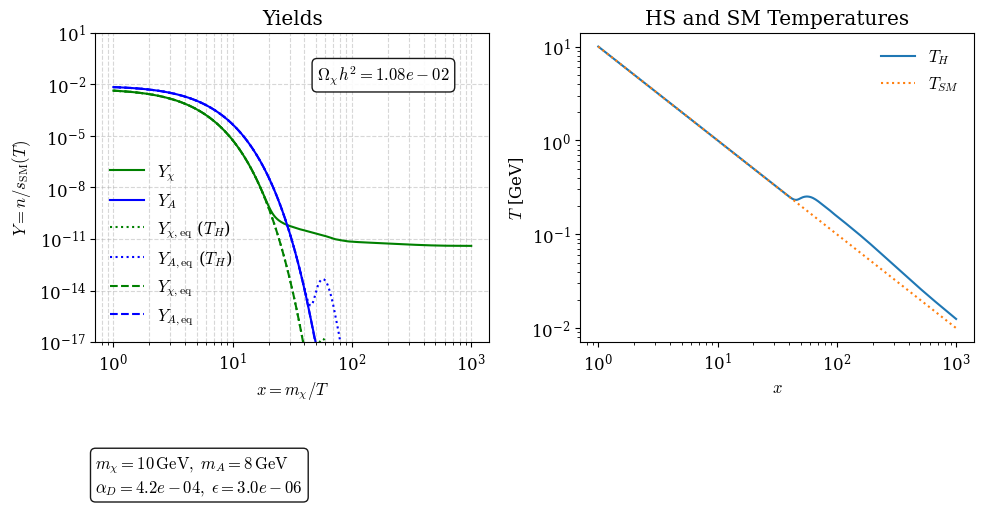

In [51]:
# Diagnostics: yields vs SM entropy
mchi = params["mchi"]
xs = x_evolve


T = mchi/xs
Th = Th_evolve
Ychi = Y(nchi_evolve, T)
YA  = Y(nA_evolve, T)
Omega_h2 = get_relic_abundance(Ychi[-1], mchi)


nchi_eq_SM = neq_stable(mchi, gchi, T)     # eq at SM temp
nA_eq_SM   = neq_stable(mA,   gA,   T)
nchi_eq_HS = neq_stable(mchi, gchi, Th)    # eq at HS temp
nA_eq_HS   = neq_stable(mA,   gA,   Th)

# convert to yields using s_SM(T)
Ychi_eq_SM = Y(nchi_eq_SM, T)
YA_eq_SM   = Y(nA_eq_SM,   T)
Ychi_eq_HS = Y(nchi_eq_HS, T)
YA_eq_HS   = Y(nA_eq_HS,   T)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].loglog(xs, Ychi, color = "green", label=r'$Y_\chi$')
ax[0].loglog(xs, YA, color = "blue", label=r'$Y_{A}$')

# plot equilibrium yields for comparison
ax[0].loglog(xs, Ychi_eq_HS, ':',  color = "green", label=r'$Y_{\chi,{\rm eq}}$ ($T_H$)')
ax[0].loglog(xs, YA_eq_HS,  ':', color = "blue", label=r'$Y_{A,{\rm eq}}$ ($T_H$)')
ax[0].loglog(xs, Ychi_eq_SM, '--',  color = "green", label=r'$Y_{\chi,{\rm eq}}$ ')
ax[0].loglog(xs, YA_eq_SM,  '--', color = "blue", label=r'$Y_{A,{\rm eq}}$')

ax[0].set_ylim(1e-17, 1e1)

ax[0].set_xlabel(r'$x=m_\chi/T$'); ax[0].set_ylabel(r'$Y=n/s_{\rm SM}(T)$'); ax[0].legend(frameon=False)
ax[0].set_title('Yields')

# add text annotation for model parameters
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])

param_text_ic = {
    r"$T_H = T$ at $x=%.1f$" % (x_i,),
    r"$n_\chi = %.1e$ at $x=%.1f$" % (nchi_i, x_i),
    r"$n_A = %.1e$ at $x=%.1f$" % (nA_i, x_i),
}
ax[0].text(
    0.0,-0.5, param_text,
    transform=ax[0].transAxes,
    va='bottom', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

# add text annotation for relic abundance
relic_text = r"$\Omega_\chi h^2 = %.2e$" % (Omega_h2)
ax[0].text(
    0.9,0.9, relic_text,
    transform=ax[0].transAxes,
    va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].loglog(xs, Th, label = r'$T_H$')
ax[1].loglog(xs, T, ':', label=r'$T_{SM}$')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$T$ [GeV]'); ax[1].legend(frameon=False)
ax[1].set_title('HS and SM Temperatures')



plt.tight_layout()
plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_12267/4082859795.py:40: SyntaxWarning: invalid escape sequence '\c'
  plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")


(1e-10, 10000000000.0)

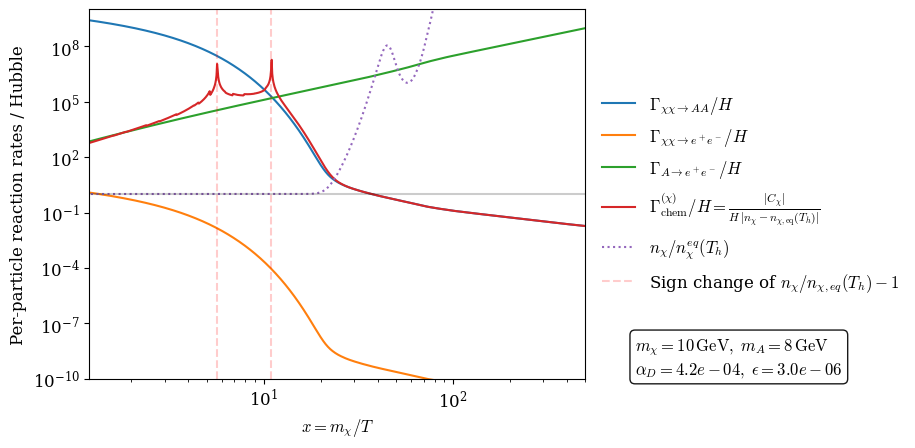

In [ ]:
# plot diagnostics
diag = result["diag"]
Gamma_xAA_over_H = diag["Gamma_xAA_over_H"]
Gamma_xSM_over_H = diag["Gamma_xSM_over_H"]
Gamma_Adec_over_H = diag["Gamma_Adec_over_H"]
gamma_chem_over_H = diag["Gamma_chem_over_H"]

label_chem = (r'$\Gamma_{\mathrm{chem}}^{(\chi)}/H'
         r' = \frac{|C_\chi|}{H\,|n_\chi - n_{\chi,\mathrm{eq}}(T_h)|}$')

nx_ratio = diag["nchi_over_nchieq"]
nA_ratio = diag["nA_over_nAeq"]
ratio_ratio = nx_ratio / nA_ratio
#PLOT
plt.figure()
plt.loglog(x_evolve, Gamma_xAA_over_H, label=r"$\Gamma_{\chi\chi \to AA} / H$")
plt.loglog(x_evolve, Gamma_xSM_over_H, label=r"$\Gamma_{\chi\chi \to e^+e^-} / H$")
plt.loglog(x_evolve, Gamma_Adec_over_H, label=r"$\Gamma_{A \to e^+e^-} / H$")
plt.loglog(x_evolve, gamma_chem_over_H, label= label_chem)

#plt.loglog(x_evolve, np.minimum(diag["dep_chi"], 1000000000), ls='--', label=r"$n_\chi / n_\chi^{eq}(T_h)$")

# cap_depchi = np.minimum(diag["dep_chi"], 1e50)
# print(cap_depchi)
# plt.plot(x_evolve, cap_depchi,   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, diag["dep_A"],   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")

cap_nx_ratio = np.minimum(nx_ratio, 1e20)
cap_nA_ratio = np.minimum(nA_ratio, 1e20)

plt.loglog(x_evolve, cap_nx_ratio,   ls=':', label=r"$n_\chi / n_\chi^{eq}(T_h)$")
#plt.loglog(x_evolve, cap_nA_ratio,   ls='-.', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, ratio_ratio,   ls=':', label=r"($n_\chi / n_\chi^{eq}(T_h)) \; / \; (n_A / n_A^{eq}(T_h)$)")


diffs = np.diff(np.sign(cap_nx_ratio - 1))
sign_changes = np.where(diffs != 0)[0]
for (i, idx) in enumerate(sign_changes):
    if i == 0:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of $n_\chi / n_{\chi,eq}(T_h) - 1$")
    else:
        plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2)


params = diag["params"]
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])

plt.text(1.1, 0, param_text,
            transform=plt.gca().transAxes,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, borderaxespad=0., handlelength=2, labelspacing=0.6)
plt.xlabel(r"$x = m_\chi / T$")
plt.ylabel(r"Per-particle reaction rates / Hubble")
plt.axhline(1.0, color='k', ls='-', alpha = 0.2)
plt.xlim(1.2, 500)
plt.ylim(1e-10, 1e10)


# xs = x_evolve
# plt.figure()
# #plt.loglog(xs, Cchi_over_Hn, label=r"$C_\chi / H n_\chi$")
# #plt.loglog(xs, CA_over_Hn, label=r"$C_A / H n_A$")

# plt.loglog(xs, -Cchi_evolve, label=r"$-  C_\chi$")
# plt.loglog(xs, CA_evolve, label=r"$C_A$")
# plt.loglog(xs, -Qh_evolve, label=r"$- Q_h$")

# #plt.loglog(xs, -Cchi_evolve + CA_evolve, label=r"$C_\chi + C_A$")

# #plt.plot(xs, Qh_evolve, label=r"$Q_h$")
# #plt.axhline(1.0, color='k', ls='--')
# plt.xlim(1.01, 500)
# plt.xlabel(r"$x = m_\chi / T$")
# plt.ylabel(r"Collision terms (GeV$^4$)")
#plt.legend()

In [ ]:
# do a linear fit to the HS temperature at late times (x > 100)
from scipy.stats import linregress
mask = xs > 100.0
slope, intercept, r_value, p_value, std_err = linregress(np.log(xs[mask]), np.log(Th_evolve[mask]))
print("Late-time Th fit: Th = %.3e x + %.3e" % (slope, intercept))

# plot
fig, ax = plt.subplots()
ax.loglog(xs, Th_evolve, label=r'$T_H$ from evolve')
ax.loglog(xs, np.exp(intercept) * xs**slope, '--', label=r'Linear regression for x > 100: $T_H = \propto x^{%.2f}$' % (slope))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$T_H$ [GeV]')
plt.legend()


In [ ]:
# alpha = 3e-5 #10
# epsilon =  3e-6
# mchi = 10
# mA = 5

# gchi = 2
# gA = 3

# sv_xxAA = sigma_xx_to_AA(alpha, mchi, mA) #GeV^-2
# sv_xxee = sigmav_chichi_ee(epsilon, alpha, mchi, mA)
# gamma = gammaA_ee(epsilon, mA) #GeV


# paramsA = {
#     "mchi": mchi,
#     "mA":   mA,
#     "alphaD": alpha,
#     "epsilon": epsilon,
#     "sv_xxee": sv_xxee,
#     "sv_xxAA": sv_xxAA,
#     #"sv_AAxx": sv_AAxx,
#     #"sv_xxff": sv_xxff,
#     "t_dep": True,
#     "gamma_Aee": gamma,
#     "gchi": gchi,
#     "gA": gA}


# x_i, x_f = 1.0, 1000.0
# T_i = mchi / x_i

# Th_i = T_i
# nchi_i = neq(mchi, gchi, Th_i)
# nA_i  = neq(mA,  gA,  Th_i)
# y0 = np.array([nchi_i, nA_i, Th_i])
# xs  = np.geomspace(x_i, x_f, 1000)

# paramsB = paramsA.copy()
# paramsB["alphaD"] = alpha * 2
# paramsB["sv_xxAA"] = sigma_xx_to_AA(paramsB["alphaD"], mchi, mA) #GeV^-2
# paramsB["sv_xxee"] = sigmav_chichi_ee(epsilon, paramsB["alphaD"], mchi, mA)

# paramsC = paramsA.copy()
# paramsC["alphaD"] = alpha * 4
# paramsC["sv_xxAA"] = sigma_xx_to_AA(paramsC["alphaD"], mchi, mA) #GeV^-2
# paramsC["sv_xxee"] = sigmav_chichi_ee(epsilon, paramsC["alphaD"], mchi, mA)

# paramsD = paramsA.copy()
# paramsD["alphaD"] = alpha * 8
# paramsD["sv_xxAA"] = sigma_xx_to_AA(paramsD["alphaD"], mchi, mA) #GeV^-2
# paramsD["sv_xxee"] = sigmav_chichi_ee(epsilon, paramsD["alphaD"], mchi, mA)

# resultsA = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
# resultsB = evolve(paramsB, x_i, x_f, y0, xs, log_space = True)
# resultsC = evolve(paramsC, x_i, x_f, y0, xs, log_space = True)
# resultsD = evolve(paramsD, x_i, x_f, y0, xs, log_space = True)


# omegah2A = get_relic_abundance(Y(np.exp(resultsA["sol"][0,-1]), mchi), mchi)
# omegah2B = get_relic_abundance(Y(np.exp(resultsB["sol"][0,-1]), mchi), mchi)
# omegah2C = get_relic_abundance(Y(np.exp(resultsC["sol"][0,-1]), mchi), mchi)
# omegah2D = get_relic_abundance(Y(np.exp(resultsD["sol"][0,-1]), mchi), mchi)


In [ ]:
alpha = 1.2e-4
epsilon =  3e-6
mchi = 10
mA = 1

gchi = 2
gA = 3

sv_xxAA = sigma_xx_to_AA(alpha, mchi, mA) #GeV^-2
sv_xxee = sigmav_chichi_ee(epsilon, alpha, mchi, mA)
gamma = gammaA_ee(epsilon, mA) #GeV

def make_params(mchi, mA, alphaD, eps, gchi = 2, gA = 3, E_avg = False):
    return {
        "mchi": mchi, "mA": mA,
        "alphaD": alphaD, "epsilon": eps,
        "sv_xxAA": sigma_xx_to_AA(alphaD, mchi, mA),
        "sv_xxee": sigmav_chichi_ee(eps, alphaD, mchi, mA),
        "gamma_Aee": gammaA_ee(eps, mA),
        "t_dep": True, "gchi": gchi, "gA": gA,
        "E_avg": E_avg
           }


paramsA = make_params(mchi, 1, alpha, epsilon, gchi, E_avg = True)
paramsB = make_params(mchi, 2, alpha, epsilon, gchi, gA, E_avg = True)
paramsC = make_params(mchi, 4, alpha, epsilon, gchi, gA, E_avg = True)
paramsD = make_params(mchi, 8, alpha, epsilon, gchi, gA, E_avg = True)

# paramsA = make_params(mchi, 1, alpha*4, epsilon, gchi, gA, E_avg = True)
# paramsB = make_params(mchi, 2, alpha*4*np.sqrt(2), epsilon, gchi, gA, E_avg = True)
# paramsC = make_params(mchi, 4, alpha*4*2, epsilon, gchi, gA, E_avg = True)
# paramsD = make_params(mchi, 8, alpha*8, epsilon, gchi, gA, E_avg = True)


x_i, x_f = 1.0, 2000.0
T_i = mchi / x_i

Th_i = T_i
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)
y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

resultsA = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
resultsB = evolve(paramsB, x_i, x_f, y0, xs, log_space = True)
resultsC = evolve(paramsC, x_i, x_f, y0, xs, log_space = True)
resultsD = evolve(paramsD, x_i, x_f, y0, xs, log_space = True)


/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_14843/3314773396.py:58: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ":" (-> linestyle=':'). The keyword argument will take precedence.
  ax[0].loglog(xs, Ychi_eq, ":",  alpha=0.6, ls = "--", color = 'grey', label = rf"$Y_\chi$ eq, SM.")
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_14843/3314773396.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False, fontsize=11, ncol=1)


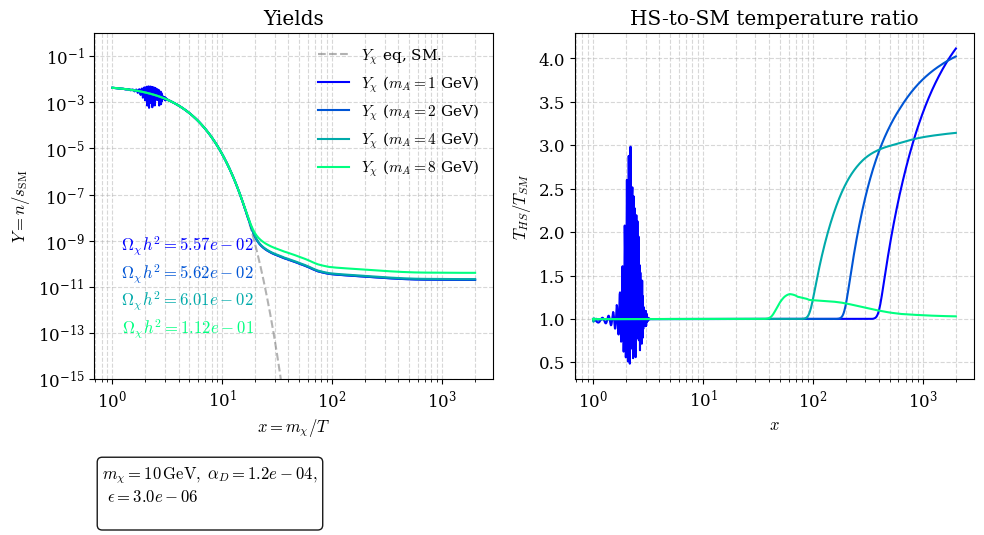

In [148]:

palette = plt.get_cmap("winter", 4)

# runs = [
#     {"params": paramsA, "result": resultsA,
#      "label": r"$\alpha_D = 3\times10^{-5}$", "color": palette(0)},
#     {"params": paramsB, "result": resultsB,
#      "label": r"$\alpha_D = 6\times10^{-5}$", "color": palette(1),  },
#     {"params": paramsC, "result": resultsC,
#      "label": r"$\alpha_D = 1.2\times10^{-4}$", "color": palette(2)},
#     {"params": paramsD, "result": resultsD,
#         "label": r"$\alpha_D = 2.4\times10^{-4}$", "color": palette(3)},
# ]

runs = [
    {"params": paramsA, "result": resultsA,
     "label": r"$m_A = 1$ GeV", "color": palette(0)},
    {"params": paramsB, "result": resultsB,
     "label": r"$m_A = 2$ GeV", "color": palette(1),  },
    {"params": paramsC, "result": resultsC,
     "label": r"$m_A = 4$ GeV", "color": palette(2)},
    {"params": paramsD, "result": resultsD,
        "label": r"$m_A = 8$ GeV", "color": palette(3)},
]

# --- CONFIG ---
ylims = (1e-15, 1e0)
show_eq = True
show_param_box_first = True
show_relic_boxes = True

# --- STYLE ---
ls_cycle = cycle(['-', '--', '-.', ':'])
col_chi, col_A = "green", "blue"


fig, ax = plt.subplots(1, 2, figsize=(10, 6))
go = True

for i, run in enumerate(runs):
    params = run["params"]
    mchi = float(params["mchi"])
    res = run["result"]
    nchi, nA, Th = res["sol"]
    x = res["x_arr"]
    T = mchi / x

    Ychi = Y(np.asarray(nchi), T)
    YA   = Y(np.asarray(nA),   T)

    lbl_run = run.get("label", f"run {i+1}")
    ls = next(ls_cycle)

    if show_eq and go:
        gchi = params.get("gchi", None)
        gA   = params.get("gA",   None)
        Ychi_eq = Y(neq(params["mchi"], gchi, T), T)
        YA_eq   = Y(neq(params["mA"],   gA,   T), T)
        ax[0].loglog(xs, Ychi_eq, ":",  alpha=0.6, ls = "--", color = 'grey', label = rf"$Y_\chi$ eq, SM.")
        go = False
        #ax[0].loglog(xs, YA_eq,   ":", color=col_A,  alpha=0.6, label=rf"$Y_A$")

    # --- Yields (per run) ---
    c = run.get("color", None)
    ax[0].loglog(xs, Ychi, color=c, label=rf"$Y_\chi$ ({lbl_run})", ls = "-")
    #ax[0].loglog(xs, YA,   ls=ls, color=col_A,  label=rf"$Y_A$ ({lbl_run})")

    # --- Equilibrium  ---


    # --- Per-run relic abundance box  ---
    if show_relic_boxes:
        omegah2 = get_relic_abundance(Ychi[-1], mchi)
        relic_text = r"$\Omega_\chi h^2 = {:.2e}$".format(omegah2)
        y_anchor = 0.42 - 0.08*(i % 6)  # stagger to avoid overlap
        ax[0].text(
            0.4, y_anchor, relic_text,
            transform=ax[0].transAxes, va='top', ha='right', color = c,
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.4),
            clip_on=False
        )

    # --- Temperature ratio ---
    ax[1].plot(xs, Th/T, ls="-", color=c)
    # ax[1].plot(xs, Th, color=c, label=rf"$T_H$ ({lbl_run})", ls = "-")
    # ax[1].plot(xs, T, ':', color='grey', alpha=0.6, label=r"$T_{SM}$")

    if i == 0 and show_param_box_first:
        param_text = (
    #r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$m_\chi = %.0f\,\mathrm{GeV},\; \alpha_D = %.1e,$" "\n"
    r" $ \epsilon = %.1e$" "\n"
    #r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    #r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["alphaD"], params["epsilon"])
        ax[0].text(
            0.02, -0.42, param_text,
            transform=ax[0].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

# --- Cosmetics ---
ax[0].set_ylim(*ylims)
ax[0].set_xlabel(r"$x = m_\chi/T$")
ax[0].set_ylabel(r"$Y = n/s_{\rm SM}$")
ax[0].set_title("Yields")
ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$T_{HS}/T_{SM}$")
ax[1].set_title("HS-to-SM temperature ratio")
ax[1].grid(True, which='both', ls='--', alpha=0.5)

ax[0].legend(frameon=False, fontsize=11, ncol=1, framealpha=0.4)
ax[1].legend(frameon=False, fontsize=11, ncol=1)
ax[1].set_xscale('log')
#ax[1].set_yscale('log')


plt.tight_layout()
plt.show()


In [178]:
print(paramsB)

{'mchi': 10, 'mA': 2, 'alphaD': 0.00012, 'epsilon': 3e-06, 'sv_xxAA': np.float64(4.4306461104933644e-10), 'sv_xxee': np.float64(2.5268686763506017e-19), 'gamma_Aee': np.float64(4.379562043795621e-14), 't_dep': True, 'gchi': 2, 'gA': 3, 'E_avg': True}


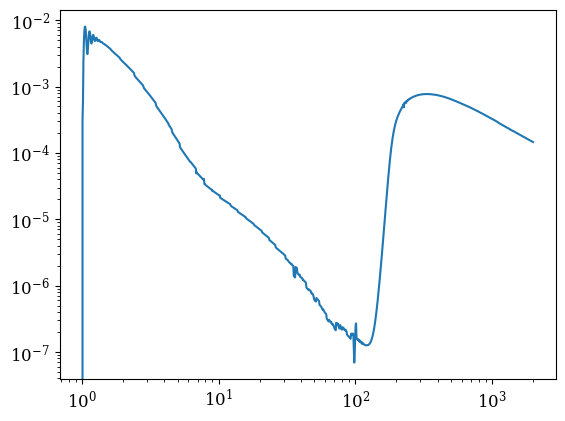

In [116]:
A_temp = resultsA["sol"][1]; B_temp = resultsB["sol"][1]
temp_diff = np.abs(A_temp - B_temp) / np.maximum(A_temp, B_temp)
plt.figure()
plt.loglog(xs, temp_diff)


(1e-15, 1000000000000000.0)

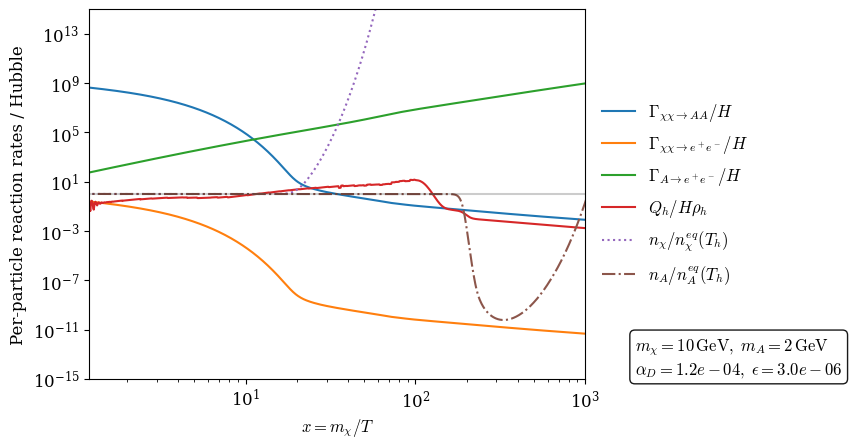

In [150]:
# plot diagnostics
diag = resultsB["diag"]
Gamma_xAA_over_H = diag["Gamma_xAA_over_H"]
Gamma_xSM_over_H = diag["Gamma_xSM_over_H"]
Gamma_Adec_over_H = diag["Gamma_Adec_over_H"]
gamma_chem_over_H = diag["Gamma_chem_over_H"]
Qh_over_Hrho = diag["Q_over_Hrho"]
x_evolve = diag["x"]

label_chem = (r'$\Gamma_{\mathrm{chem}}^{(\chi)}/H'
         r' = \frac{|C_\chi|}{H\,|n_\chi - n_{\chi,\mathrm{eq}}(T_h)|}$')

nx_ratio = diag["nchi_over_nchieq"]
nA_ratio = diag["nA_over_nAeq"]
ratio_ratio = nx_ratio / nA_ratio
cap_gamma_chem_over_H = np.minimum(gamma_chem_over_H, 1e20)
#PLOT
plt.figure()
plt.loglog(x_evolve, Gamma_xAA_over_H, label=r"$\Gamma_{\chi\chi \to AA} / H$")
plt.loglog(x_evolve, Gamma_xSM_over_H, label=r"$\Gamma_{\chi\chi \to e^+e^-} / H$")
plt.loglog(x_evolve, Gamma_Adec_over_H, label=r"$\Gamma_{A \to e^+e^-} / H$")
# plt.loglog(x_evolve, cap_gamma_chem_over_H, label= label_chem)
plt.loglog(x_evolve, Qh_over_Hrho, label=r"$Q_h / H \rho_h$")

#plt.loglog(x_evolve, np.minimum(diag["dep_chi"], 1000000000), ls='--', label=r"$n_\chi / n_\chi^{eq}(T_h)$")

# cap_depchi = np.minimum(diag["dep_chi"], 1e50)
# print(cap_depchi)
# plt.plot(x_evolve, cap_depchi,   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, diag["dep_A"],   ls='--', label=r"$n_A / n_A^{eq}(T_h)$")

cap_nx_ratio = np.minimum(nx_ratio, 1e20)
cap_nA_ratio = np.minimum(nA_ratio, 1e20)

plt.loglog(x_evolve, cap_nx_ratio,   ls=':', label=r"$n_\chi / n_\chi^{eq}(T_h)$")
plt.loglog(x_evolve, cap_nA_ratio,   ls='-.', label=r"$n_A / n_A^{eq}(T_h)$")
#plt.loglog(x_evolve, ratio_ratio,   ls=':', label=r"($n_\chi / n_\chi^{eq}(T_h)) \; / \; (n_A / n_A^{eq}(T_h)$)")


# diffs = np.diff(np.sign(cap_nx_ratio - 1))
# sign_changes = np.where(diffs != 0)[0]
# for (i, idx) in enumerate(sign_changes):
#     if i == 0:
#         plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2, label = "Sign change of ($n_\chi / n_{\chi,eq}(T_h)) - 1$")
#     else:
#         plt.axvline(x_evolve[idx], color='red', ls='--', alpha=0.2)


params = diag["params"]
param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (params["mchi"], params["mA"],
     params["alphaD"], params["epsilon"])

plt.text(1.1, 0, param_text,
            transform=plt.gca().transAxes,
            va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False)

plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, borderaxespad=0., handlelength=2, labelspacing=0.6)
plt.xlabel(r"$x = m_\chi / T$")
plt.ylabel(r"Per-particle reaction rates / Hubble")
plt.axhline(1.0, color='k', ls='-', alpha = 0.2)
plt.xlim(1.2, 1000)

l = 20
plt.ylim(1e-15, 1e15)


In [154]:
# now, let's check that for this best value, there is minimal sensitivity to epsilon
alpha = 1.2e-4
epsilon =  3e-5
mchi = 10 # 0.3
mA = 8 # 0.3*0.7

gchi = 2
gA = 3
paramsAe = make_params(mchi, mA, alpha, epsilon) #, E_avg= True)
paramsBe = make_params(mchi, mA, alpha, epsilon / 10) #, E_avg= True)
paramsCe = make_params(mchi, mA, alpha, epsilon / 100) #, E_avg= True)
paramsDe = make_params(mchi, mA, alpha, epsilon / 1000) #, E_avg= True)
paramsEe = make_params(mchi, mA, alpha, epsilon / 10000) #, E_avg= True)


x_i, x_f = 1.0, 1000.0
T_i = mchi / x_i
Th_i = T_i  # start with HS in kinetic eq. with SM (Th = T)
nchi_i = neq(mchi, gchi, Th_i)
nA_i  = neq(mA,  gA,  Th_i)

y0 = np.array([nchi_i, nA_i, Th_i])
xs  = np.geomspace(x_i, x_f, 1000)

resultsAe = evolve(paramsAe, x_i, x_f, y0, xs, log_space = True)
resultsBe = evolve(paramsBe, x_i, x_f, y0, xs, log_space = True)
resultsCe = evolve(paramsCe, x_i, x_f, y0, xs, log_space = True)
resultsDe = evolve(paramsDe, x_i, x_f, y0, xs, log_space = True)
resultsEe = evolve(paramsEe, x_i, x_f, y0, xs, log_space = True)

print("DONE")

omegah2Ae = get_relic_abundance(Y(np.exp(resultsAe["sol"][0,-1]), mchi), mchi)
omegah2Be = get_relic_abundance(Y(np.exp(resultsBe["sol"][0,-1]), mchi), mchi)
omegah2Ce = get_relic_abundance(Y(np.exp(resultsCe["sol"][0,-1]), mchi), mchi)
omegah2De = get_relic_abundance(Y(np.exp(resultsDe["sol"][0,-1]), mchi), mchi)
omegah2Ee = get_relic_abundance(Y(np.exp(resultsEe["sol"][0,-1]), mchi), mchi)


DONE


In [152]:
for params in [paramsAe, paramsBe, paramsCe, paramsDe, paramsEe]:
    print("Epsilon: %.1e" % (params["epsilon"],))
    print("  sv_xxee: %.3e cm^3/s" % (params["sv_xxee"] * Gev2_to_cm3s,))

Epsilon: 3.0e-05
  sv_xxee: 4.097e-34 cm^3/s
Epsilon: 3.0e-06
  sv_xxee: 4.097e-36 cm^3/s
Epsilon: 3.0e-07
  sv_xxee: 4.097e-38 cm^3/s
Epsilon: 3.0e-08
  sv_xxee: 4.097e-40 cm^3/s
Epsilon: 3.0e-09
  sv_xxee: 4.097e-42 cm^3/s


/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_14843/1249490239.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False, fontsize=13, ncol=1)


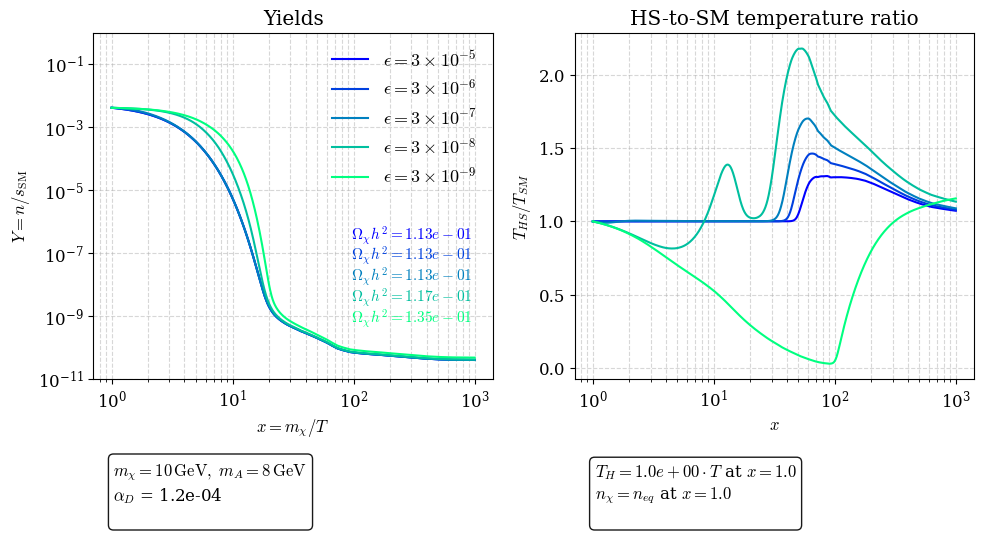

In [158]:
palette = plt.get_cmap("winter", 5)

runs = [
    {"params": paramsAe, "result": resultsAe,
     "label": r"$\epsilon = 3\times10^{-5}$", "color": palette(0),   "Omega_h2": omegah2Ae},
    {"params": paramsBe, "result": resultsBe,
     "label": r"$\epsilon = 3\times10^{-6}$", "color": palette(1),   "Omega_h2": omegah2Be},
    {"params": paramsCe, "result": resultsCe,
     "label": r"$\epsilon = 3\times10^{-7}$", "color": palette(2),  "Omega_h2": omegah2Ce},
    {"params": paramsDe, "result": resultsDe,
        "label": r"$\epsilon = 3\times10^{-8}$", "color": palette(3),  "Omega_h2": omegah2De},
    {"params": paramsEe, "result": resultsEe,
        "label": r"$\epsilon =  3\times10^{-9}$", "color": palette(4),  "Omega_h2": omegah2Ee},
]

# --- CONFIG ---
ylims = (1e-11, 1e0)
show_eq = True
show_param_box_first = True
show_relic_boxes = True

# --- STYLE ---
ls_cycle = cycle(['-', '--', '-.', ':'])
col_chi, col_A = "green", "blue"

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i, run in enumerate(runs):
    params = run["params"]
    mchi = float(params["mchi"])
    res = run["result"]
    nchi, nA, Th = res["sol"]
    x = res["x_arr"]
    T = mchi / x

    Ychi = Y(np.asarray(nchi), T)
    YA   = Y(np.asarray(nA),   T)

    lbl_run = run.get("label", f"run {i+1}")
    ls = next(ls_cycle)

    # --- Yields (per run) ---
    c = run.get("color", None)
    ax[0].loglog(xs, Ychi, color=c, label=rf"{lbl_run}", ls = "-")
    #ax[0].loglog(xs, YA,   ls=ls, color=col_A,  label=rf"$Y_A$ ({lbl_run})")

    # --- Equilibrium ---
    if show_eq:
        gchi = params.get("gchi", None)
        gA   = params.get("gA",   None)
        Ychi_eq = Y(neq(params["mchi"], gchi, T), T)
        YA_eq   = Y(neq(params["mA"],   gA,   T), T)
        #ax[0].loglog(xs, Ychi_eq, ":",  alpha=0.6, ls = "--", color = 'grey', label = rf"$Y_{{\chi,eq}}$")
        #ax[0].loglog(xs, YA_eq,   ":", color=col_A,  alpha=0.6, label=rf"$Y_A$")

    # --- Per-run relic abundance box ---
    if show_relic_boxes and ("Omega_h2" in run):
        omegah2 = get_relic_abundance(Ychi[-1], mchi)
        relic_text = r"$\Omega_\chi h^2 = {:.2e}$".format(omegah2)
        y_anchor = 0.45 - 0.06*(i % 6)  # stagger to avoid overlap
        ax[0].text(
            0.95, y_anchor, relic_text,
            transform=ax[0].transAxes, va='top', ha='right', color = c,
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False, fontsize = 11
        )

    # --- Temperature ratio ---
    ax[1].plot(xs, Th/T, ls="-", color=c)

    if i == 0 and show_param_box_first:
        param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    #r" $ \epsilon = %.1e$" "\n"
    r"$\alpha_D$ = %.1e" "\n"
    #r"$\langle\sigma v\rangle_{\chi\chi\to\mathrm{SM}} = %.1e\,\mathrm{cm^3/s},\; "
    #r"\langle\sigma v\rangle_{A A\to\chi\chi} = %.1e\,\mathrm{cm^3/s}$"
) % (params["mchi"], params["mA"], params["alphaD"])
        ax[0].text(
            0.05, -0.42, param_text,
            transform=ax[0].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

        ic_param_text = (
    r"$T_H = %.1e \cdot T$ at $x=%.1f$" "\n"
    r"$n_\chi = n_{eq}$ at $x=%.1f$" "\n"
    ) % (Th[0]/T[0], x[0], x[0])
        ax[1].text(
            0.05, -0.42, ic_param_text,
            transform=ax[1].transAxes, va='bottom', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            clip_on=False
        )

# --- Cosmetics ---
ax[0].set_ylim(*ylims)
ax[0].set_xlabel(r"$x = m_\chi/T$")
ax[0].set_ylabel(r"$Y = n/s_{\rm SM}$")
ax[0].set_title("Yields")
ax[0].grid(True, which='both', ls='--', alpha=0.5)

ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$T_{HS}/T_{SM}$")
ax[1].set_title("HS-to-SM temperature ratio")
ax[1].grid(True, which='both', ls='--', alpha=0.5)

ax[0].legend(frameon=False, fontsize=13, ncol=1)
ax[1].legend(frameon=False, fontsize=13, ncol=1)
ax[1].set_xscale('log')


plt.tight_layout()
plt.show()


Late-time Th fit: Th = -1.278e+00 x + 2.382e+00


Text(0.05, 0.15, 'Fit results:\n$T_H = 1.08e+01 \\cdot x^{-1.28}$')

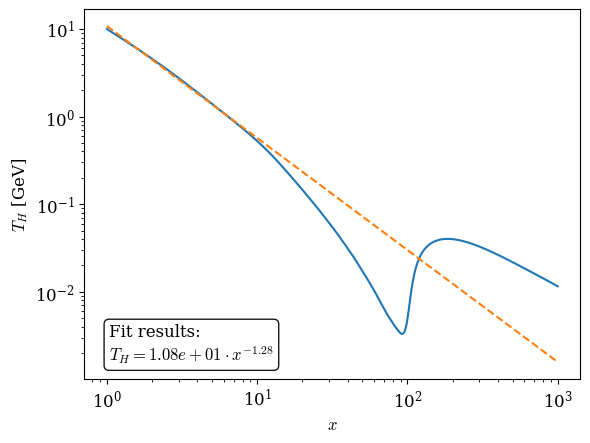

In [ ]:
# fit late-time temperature evolution for D

from scipy.stats import linregress
mask = xs < 10.0
slope, intercept, r_value, p_value, std_err = linregress(np.log(xs[mask]), np.log(Th[mask]))
print("Late-time Th fit: Th = %.3e x + %.3e" % (slope, intercept))
# plot
fig, ax = plt.subplots()
ax.loglog(xs, Th, label=r'$T_H$ from evolve')
ax.loglog(xs, np.exp(intercept) * xs**slope, '--', label=r'Linear regression for x > 100: $T_H = \propto x^{%.2f}$' % (slope))

# annotate results
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$T_H$ [GeV]')
# annotate fit results
fit_text = (
    r"Fit results:" "\n"
    r"$T_H = %.2e \cdot x^{%.2f}$"
) % (np.exp(intercept), slope)

ax.text(
    0.05, 0.15, fit_text,
    transform=ax.transAxes, va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False
)


In [169]:
# we want to check the sensitivity now to x_i
# scan over xi in [0.01, 0.1, 0.5, 1.0]

#xis = [1.0, 5.0, 20.]
alpha =1.2e-4
epsilon =  3e-6
mchi = 10 # 0.3
mA = 8 # 0.3*0.7
paramsA =make_params(mchi, mA, alpha, epsilon)
print(paramsA["sv_xxAA"] * Gev2_to_cm3s)

x_f = 1000.0

xis = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10, 15]
results =  []
for x_i in xis:
    T_i = mchi / x_i

    Th_i =  T_i  # start very cold
    nchi_i = neq(mchi, gchi, Th_i)
    nA_i  = neq(mA,  gA,  Th_i)
    y0 = np.array([nchi_i, nA_i, Th_i])  # initial conditions: n_chi, n_A, Th, H, C_chi, C_A
    xs  = np.geomspace(x_i, x_f, 1000)

    result = evolve(paramsA, x_i, x_f, y0, xs, log_space = True)
    results.append(result)
    print("Done xi = %.2f" % (x_i,))

2.466845353667679e-27
Done xi = 0.10
Done xi = 0.25
Done xi = 0.50
Done xi = 1.00
Done xi = 2.00
Done xi = 5.00
Done xi = 10.00
Done xi = 15.00


0.1
0.25
0.5
1.0
2.0
5.0
10.0
15.0
[np.float64(0.11347195035616474), np.float64(0.1134722823494437), np.float64(0.11347198352240342), np.float64(0.11347170842398746), np.float64(0.11347352999436293), np.float64(0.11347204726631344), np.float64(0.11347188606921711), np.float64(0.11347323320085338)]


Text(0, 0.5, '$\\Delta(\\Omega_\\chi h^2$) relative to $T_H = 10^{-4} T$')

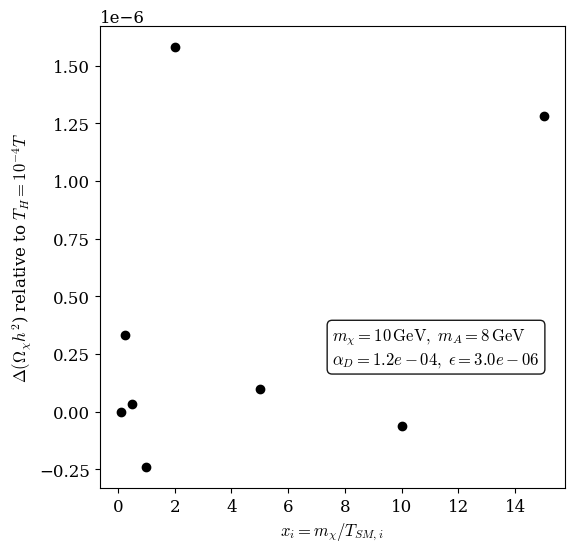

In [172]:
yields = []
abundances = []
for res in results:
    nchi_evolve, nA_evolve, Th_evolve = res["sol"]
    x_evolve = res["x_arr"]
    print(x_evolve[0])
    T_evolve = mchi / x_evolve
    Ychi = Y(nchi_evolve, T_evolve)
    Omega_h2 = get_relic_abundance(Ychi[-1], mchi)
    yields.append(Ychi)
    omegah2 = get_relic_abundance(Ychi[-1], mchi)
    abundances.append(omegah2)

print(abundances)

abundances_sub = [a - abundances[0] for a in abundances]
palette = plt.get_cmap('tab10')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(xis, abundances_sub, color='black', label = xis)


param_text = (
    r"$m_\chi = %.0f\,\mathrm{GeV},\; m_{A} = %.0f\,\mathrm{GeV}$" "\n"
    r"$\alpha_D = %.1e,\; \epsilon = %.1e$"
) % (paramsA["mchi"], paramsA["mA"],
     paramsA["alphaD"], paramsA["epsilon"])
ax.text(
    0.5, 0.35, param_text,
    transform=ax.transAxes,
    va='top', ha='left',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
    clip_on=False)

plt.xlabel(r"$x_i = m_\chi / T_{SM,i}$")
plt.ylabel(r"$\Delta(\Omega_\chi h^2$) relative to $T_H = 10^{-4} T$")
# for i, xi in enumerate(xis):
#     Ychi = yields[i]
#     c = palette(i)
#     ax.loglog(xs, Ychi, color=c, label=rf"$\xi = {xi}$", ls = "-")


In [167]:
# --- thermal xsec target
SIGMA_TARGET_GEVM2 = 3e-26 * cm3s_to_GeV2

def required_alphaD_for_AA(mchi, mA, sigma_target=SIGMA_TARGET_GEVM2, rtol=1e-3):
    lo, hi = 1e-8, 1.0
    # Expand hi until cross section exceeds target
    for _ in range(60):
        if sigma_xx_to_AA(hi, mchi, mA) >= sigma_target:
            break
        hi *= 2.0
        if hi > 4*np.pi:  # stay in non-perturbative reg.
            break
    # bisection
    for _ in range(100):
        mid = np.sqrt(lo*hi)
        smid = sigma_xx_to_AA(mid, mchi, mA)
        if abs(smid - sigma_target) <= rtol*sigma_target:
            return mid
        if smid < sigma_target:
            lo = mid
        else:
            hi = mid
    return mid

def required_epsilon_for_SM(alphaD, mchi, mA, sigma_target=SIGMA_TARGET_GEVM2, rtol=1e-3):
    lo, hi = 1e-12, 1e-1
    slo = sigmav_chichi_ee(lo, alphaD, mchi, mA)
    shi = sigmav_chichi_ee(hi, alphaD, mchi, mA)

    if slo > sigma_target:
        return lo
    while shi < sigma_target and hi < 1.0:
        hi *= 2.0
        shi = sigmav_chichi_ee(hi, alphaD, mchi, mA)
    # Bisection
    for _ in range(120):
        mid = np.sqrt(lo*hi)
        smid = sigmav_chichi_ee(mid, alphaD, mchi, mA)
        if abs(smid - sigma_target) <= rtol*sigma_target:
            return mid
        if smid < sigma_target:
            lo = mid
        else:
            hi = mid
    return mid

def required_params(mchi, mA, sigma_target=SIGMA_TARGET_GEVM2):
        alphaD = required_alphaD_for_AA(mchi, mA, sigma_target)
        epsilon = required_epsilon_for_SM(alphaD, mchi, mA, sigma_target)
        return {"alphaD": alphaD, "epsilon": epsilon, "channel": "AA"}

print(required_params(10, 8))

{'alphaD': np.float64(0.00041839070847119153), 'epsilon': np.float64(0.13748224162221725), 'channel': 'AA'}
